In [1]:
%%capture
%cd ../
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src import ROOT_DIR
from src.constants import obs_map
from src.preprocess.lab import clean_lab_data

pd.set_option('display.max_columns', 110)
pd.set_option('display.max_rows', 110)

# Lab Data

In [58]:
biochem = pd.read_parquet(f'{ROOT_DIR}/data/raw/biochemistry.parquet.gzip')
hema = pd.read_parquet(f'{ROOT_DIR}/data/raw/hematology.parquet.gzip')

## 'component-code-coding-0-display' vs 'component-code-text'
NOTE: also the timestamp format differs based on which column is used

In [114]:
lab_data = {'Hematology': hema, 'Biochemistry': biochem}
for lab_name, df in lab_data.items():
    df = clean_lab_data(df)
    df = df[df['obs_value'].notnull()]

    # there are no cases where both obs_display and obs_text are filled
    assert not any(df['obs_display'].notnull() & df['obs_text'].notnull())

    df['obs_display'] = df['obs_display'].map(obs_map[lab_name])
    df['obs_text'] = df['obs_text'].map(obs_map[lab_name])

    assert df['obs_display'].nunique() == df['obs_text'].nunique()

    lab_data[lab_name] = df

### compare process codes between the two

In [102]:
df = lab_data['Hematology']
print(df.groupby('obs_display')['proc_name'].value_counts())
print('#'*100)
print(df.groupby('obs_text')['proc_name'].value_counts())

obs_display                                      proc_name                                  
activated_partial_thromboplastin_time            aPTT                                           170730
basophil                                         CBC                                            306339
                                                 Blood Film Review (Lab Orderable)                4467
eosinophil                                       CBC                                            470165
                                                 Blood Film Review (Lab Orderable)                8925
                                                 Fluid, Cell Count and Differential                543
                                                 Synovial Fluid, Cell Count and Differential         8
hematocrit                                       CBC                                            387290
hemoglobin                                       CBC                               

In [105]:
df = lab_data['Biochemistry']
print(df.groupby('obs_display')['proc_name'].value_counts())
print('#'*100)
print(df.groupby('obs_text')['proc_name'].value_counts())

obs_display                 proc_name                                          
alanine_aminotransferase    ALT                                                    363166
albumin                     Albumin, Plasma                                        279196
                            Albumin, fluid                                            866
alkaline_phosphatase        ALP                                                    364047
aspartate_aminotransferase  AST                                                    364386
bicarbonate                 Bicarbonate, Plasma                                    209468
                            Anion Gap                                              148178
                            Bicarbonate, fluid                                          7
carbohydrate_antigen_19-9   CA 19-9                                                 19067
carcinoembryonic_antigen    Carcinoembryonic Antigen                                 2566
chloride            

### compare lab units between the two

In [110]:
df = lab_data['Hematology']
print(df.groupby('obs_display')['obs_unit'].value_counts())
print('#'*100)
print(df.groupby('obs_text')['obs_unit'].value_counts())

obs_display                                obs_unit
activated_partial_thromboplastin_time      s           170730
basophil                                   x10e9/L     245883
                                           bil/L         4467
eosinophil                                 x10e9/L     330305
                                           bil/L         8925
                                           %              388
hematocrit                                 L/L         387290
hemoglobin                                 g/L         602825
lymphocyte                                 x10e9/L     382054
                                           bil/L        16193
                                           %             2571
mean_corpuscular_hemoglobin                pg          586406
mean_corpuscular_hemoglobin_concentration  g/L         602296
mean_corpuscular_volume                    fL          387292
                                           fl          215342
mean_platelet_volu

In [111]:
df = lab_data['Biochemistry']
print(df.groupby('obs_display')['obs_unit'].value_counts())
print('#'*100)
print(df.groupby('obs_text')['obs_unit'].value_counts())

obs_display                 obs_unit
alanine_aminotransferase    U/L         363166
albumin                     g/L         280062
alkaline_phosphatase        U/L         364047
aspartate_aminotransferase  U/L         364386
bicarbonate                 mmol/L      357653
carbohydrate_antigen_19-9   kU/L         14458
carcinoembryonic_antigen    ug/L          2566
chloride                    mmol/L      771653
creatinine                  umol/L      533687
                            mmol/d         135
                            mmol/CP          1
glucose                     mmol/L      418855
lactate_dehydrogenase       U/L         207621
magnesium                   mmol/L      373283
phosphate                   mmol/L      327567
potassium                   mmol/L      637897
sodium                      mmol/L      781691
total_bilirubin             umol/L      372644
Name: obs_unit, dtype: int64
########################################################################################

### Observation value distribution

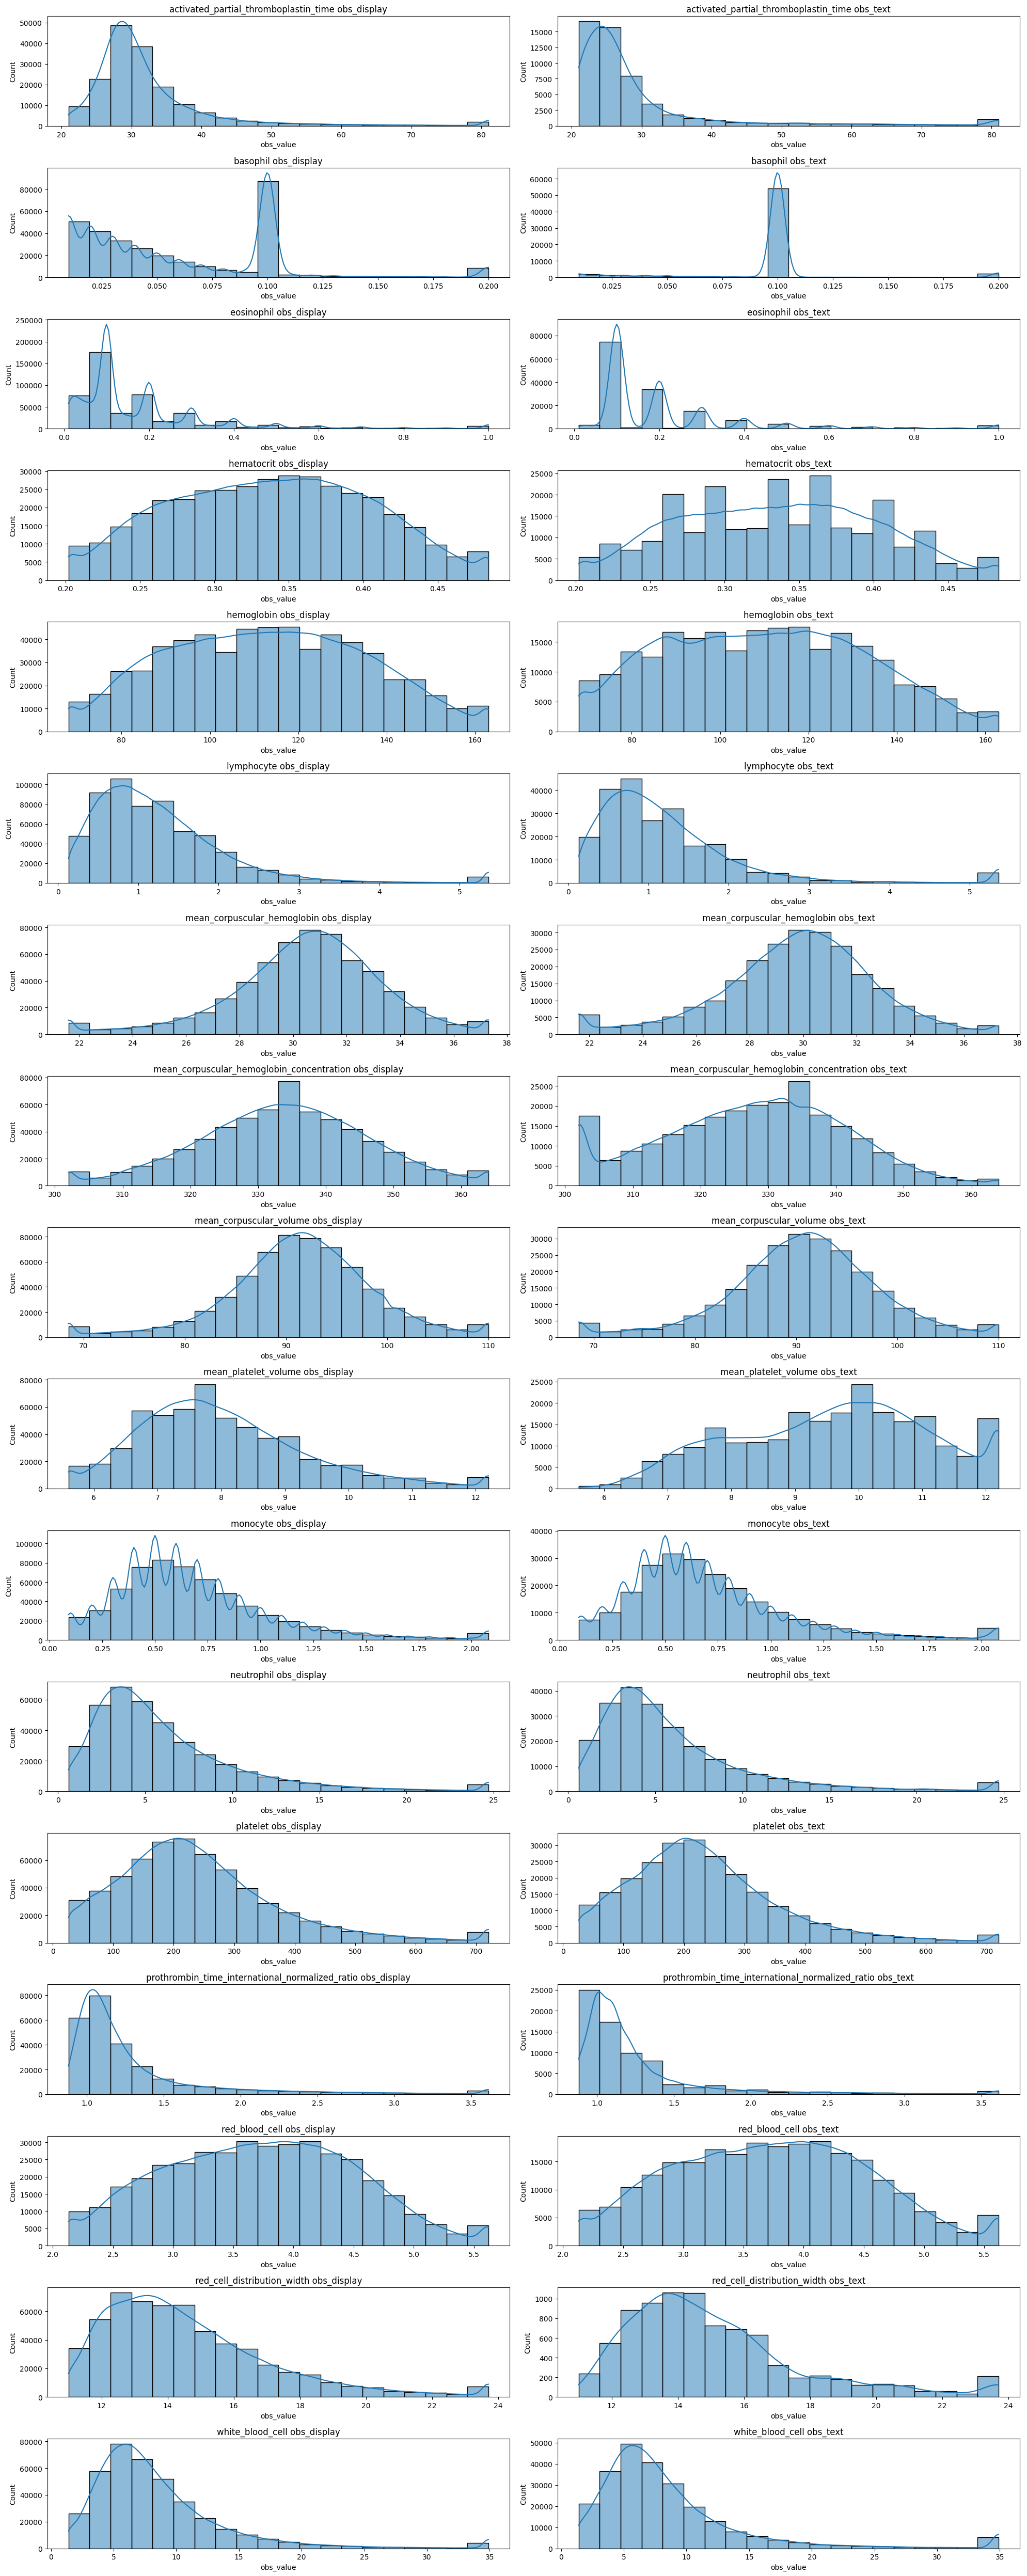

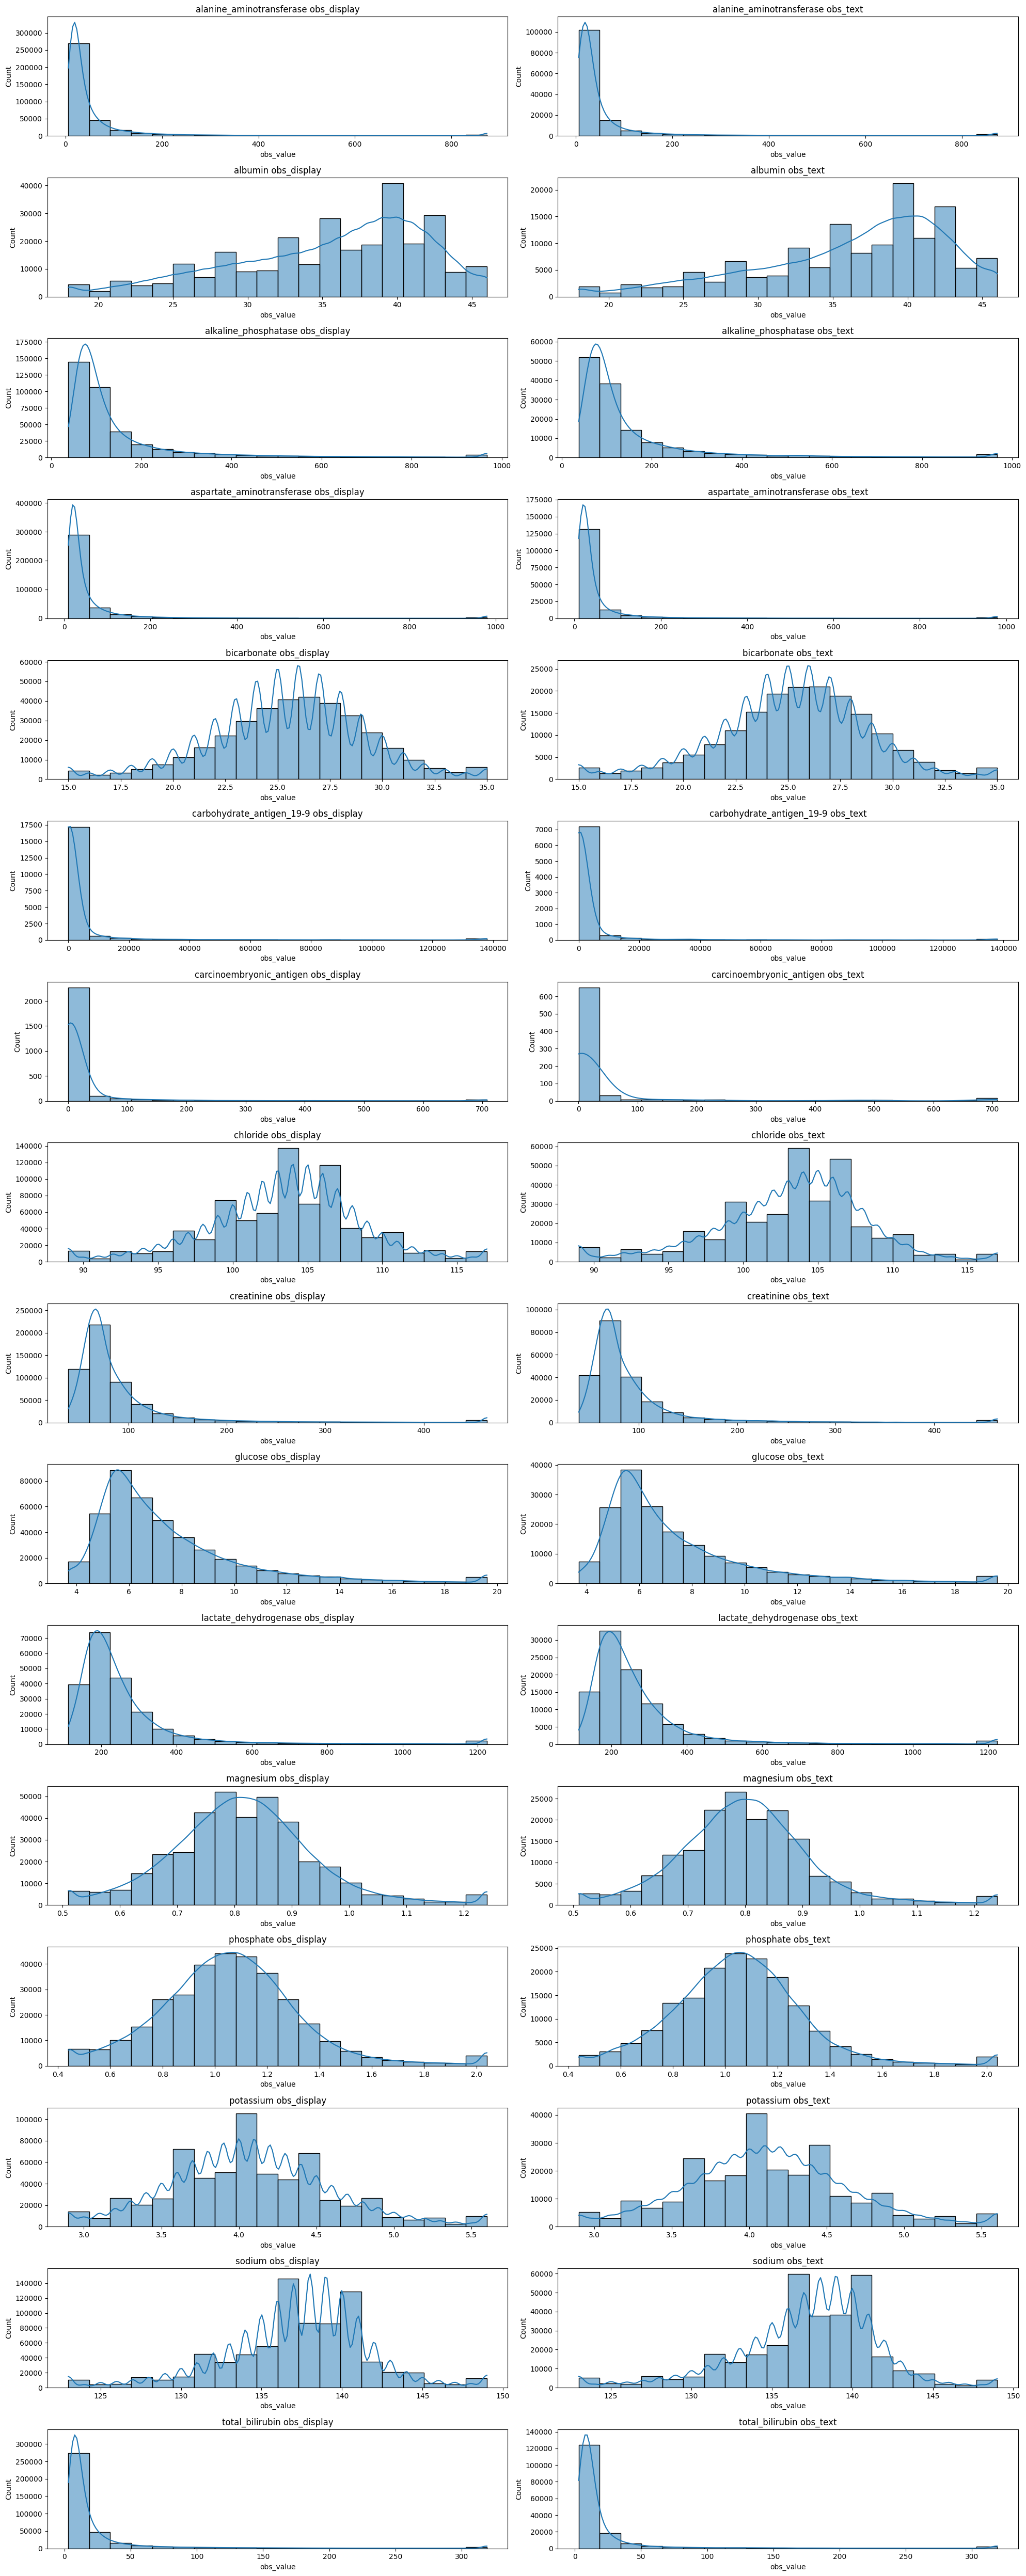

In [95]:
for lab_name, df in lab_data.items():
    fig, axes = plt.subplots(nrows=df['obs_display'].nunique(), ncols=2, figsize=(20,50))
    clip_thresh = {}
    for col_idx, col in enumerate(['obs_display', 'obs_text']):
        tmp = df[df[col].notnull()]
        for row_idx, (obs_name, obs_value) in enumerate(tmp['obs_value'].groupby(tmp[col])):
            ax = axes[row_idx, col_idx]
            if obs_name not in clip_thresh: 
                clip_thresh[obs_name] = (obs_value.quantile(0.01), obs_value.quantile(0.99))
            obs_value = obs_value.clip(*clip_thresh[obs_name])
            sns.histplot(obs_value, bins=20, kde=True, ax=ax)
            ax.set(title=f'{obs_name} {col}')
    plt.tight_layout()

## Measurement count over time

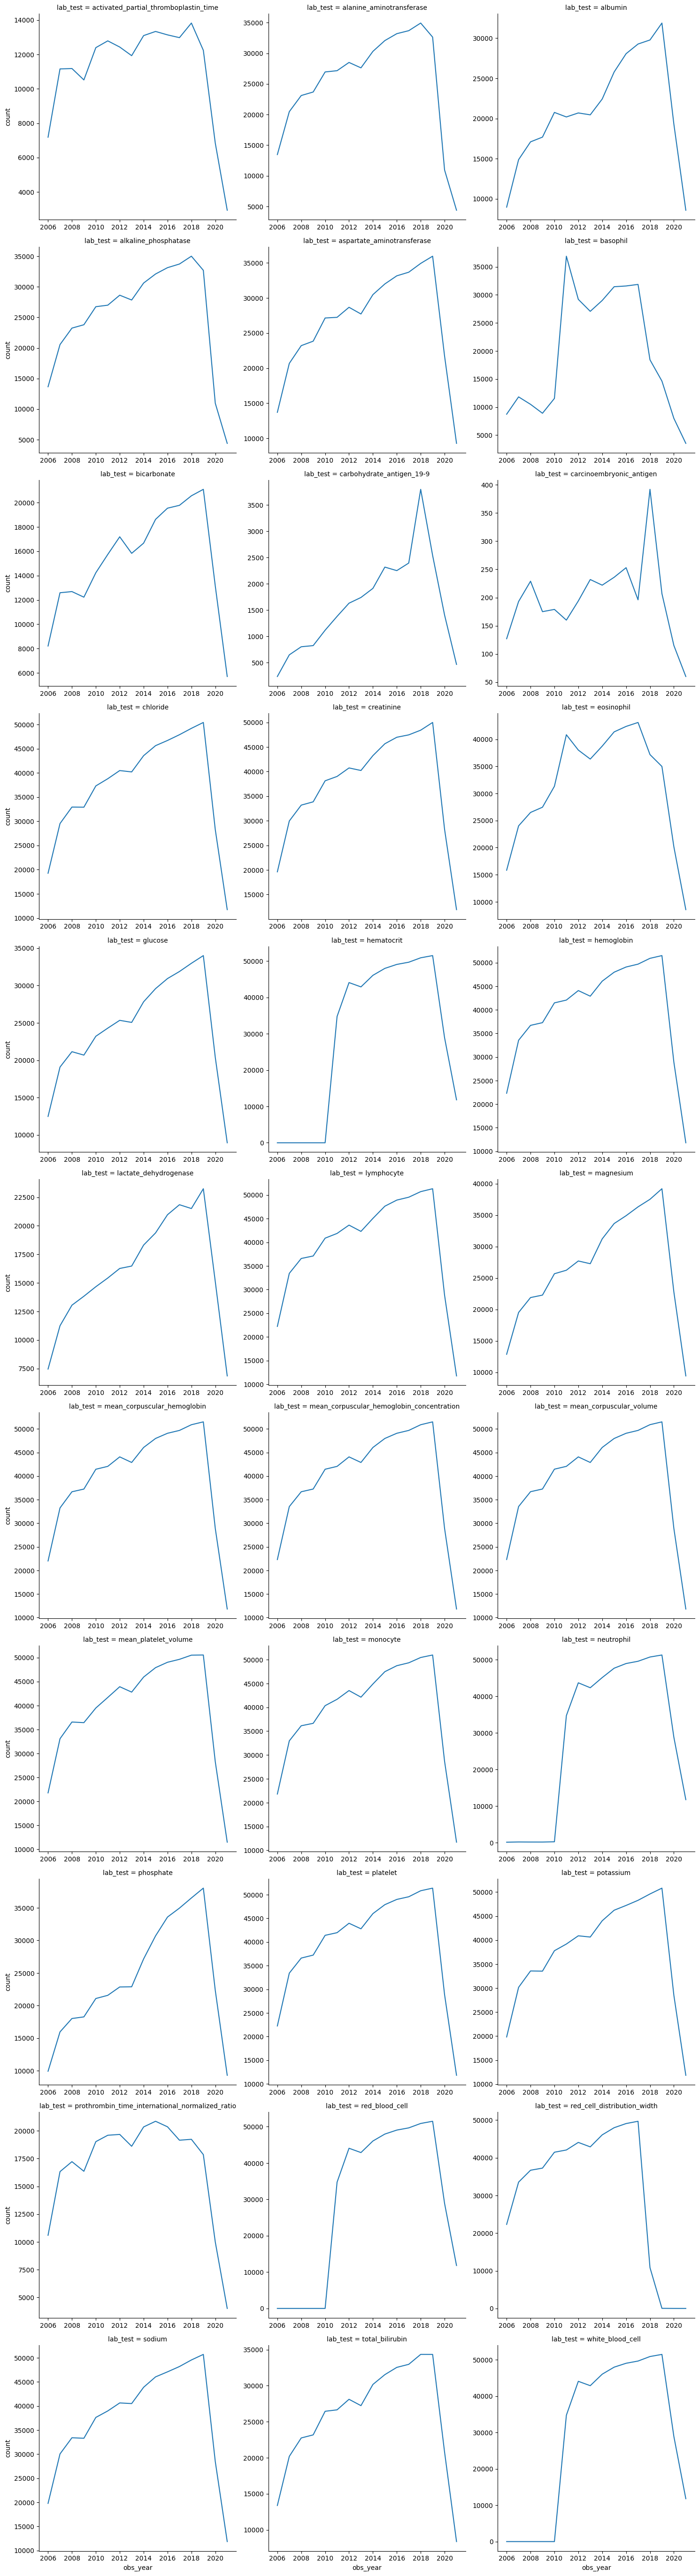

In [41]:
lab = pd.read_parquet(f'{ROOT_DIR}/data/interim/lab.parquet.gzip')
lab['obs_year'] = pd.to_datetime(lab['obs_date']).dt.year
cols = lab.columns.drop(['mrn', 'obs_year', 'obs_date'])
counts = lab.groupby('obs_year').apply(lambda g: g[cols].notnull().sum())
counts = counts.reset_index().melt('obs_year', var_name='lab_test', value_name='count')
g = sns.relplot(
    data=counts, x='obs_year', y='count', col='lab_test', col_wrap=3, kind='line', 
    facet_kws={'sharex': False, 'sharey': False}
)

# Symptom Data

In [16]:
dart = pd.read_parquet(f'{ROOT_DIR}/data/raw/dart.parquet.gzip')
symp = pd.read_parquet(f'{ROOT_DIR}/data/interim/symptom.parquet.gzip')

## Measurement count over time

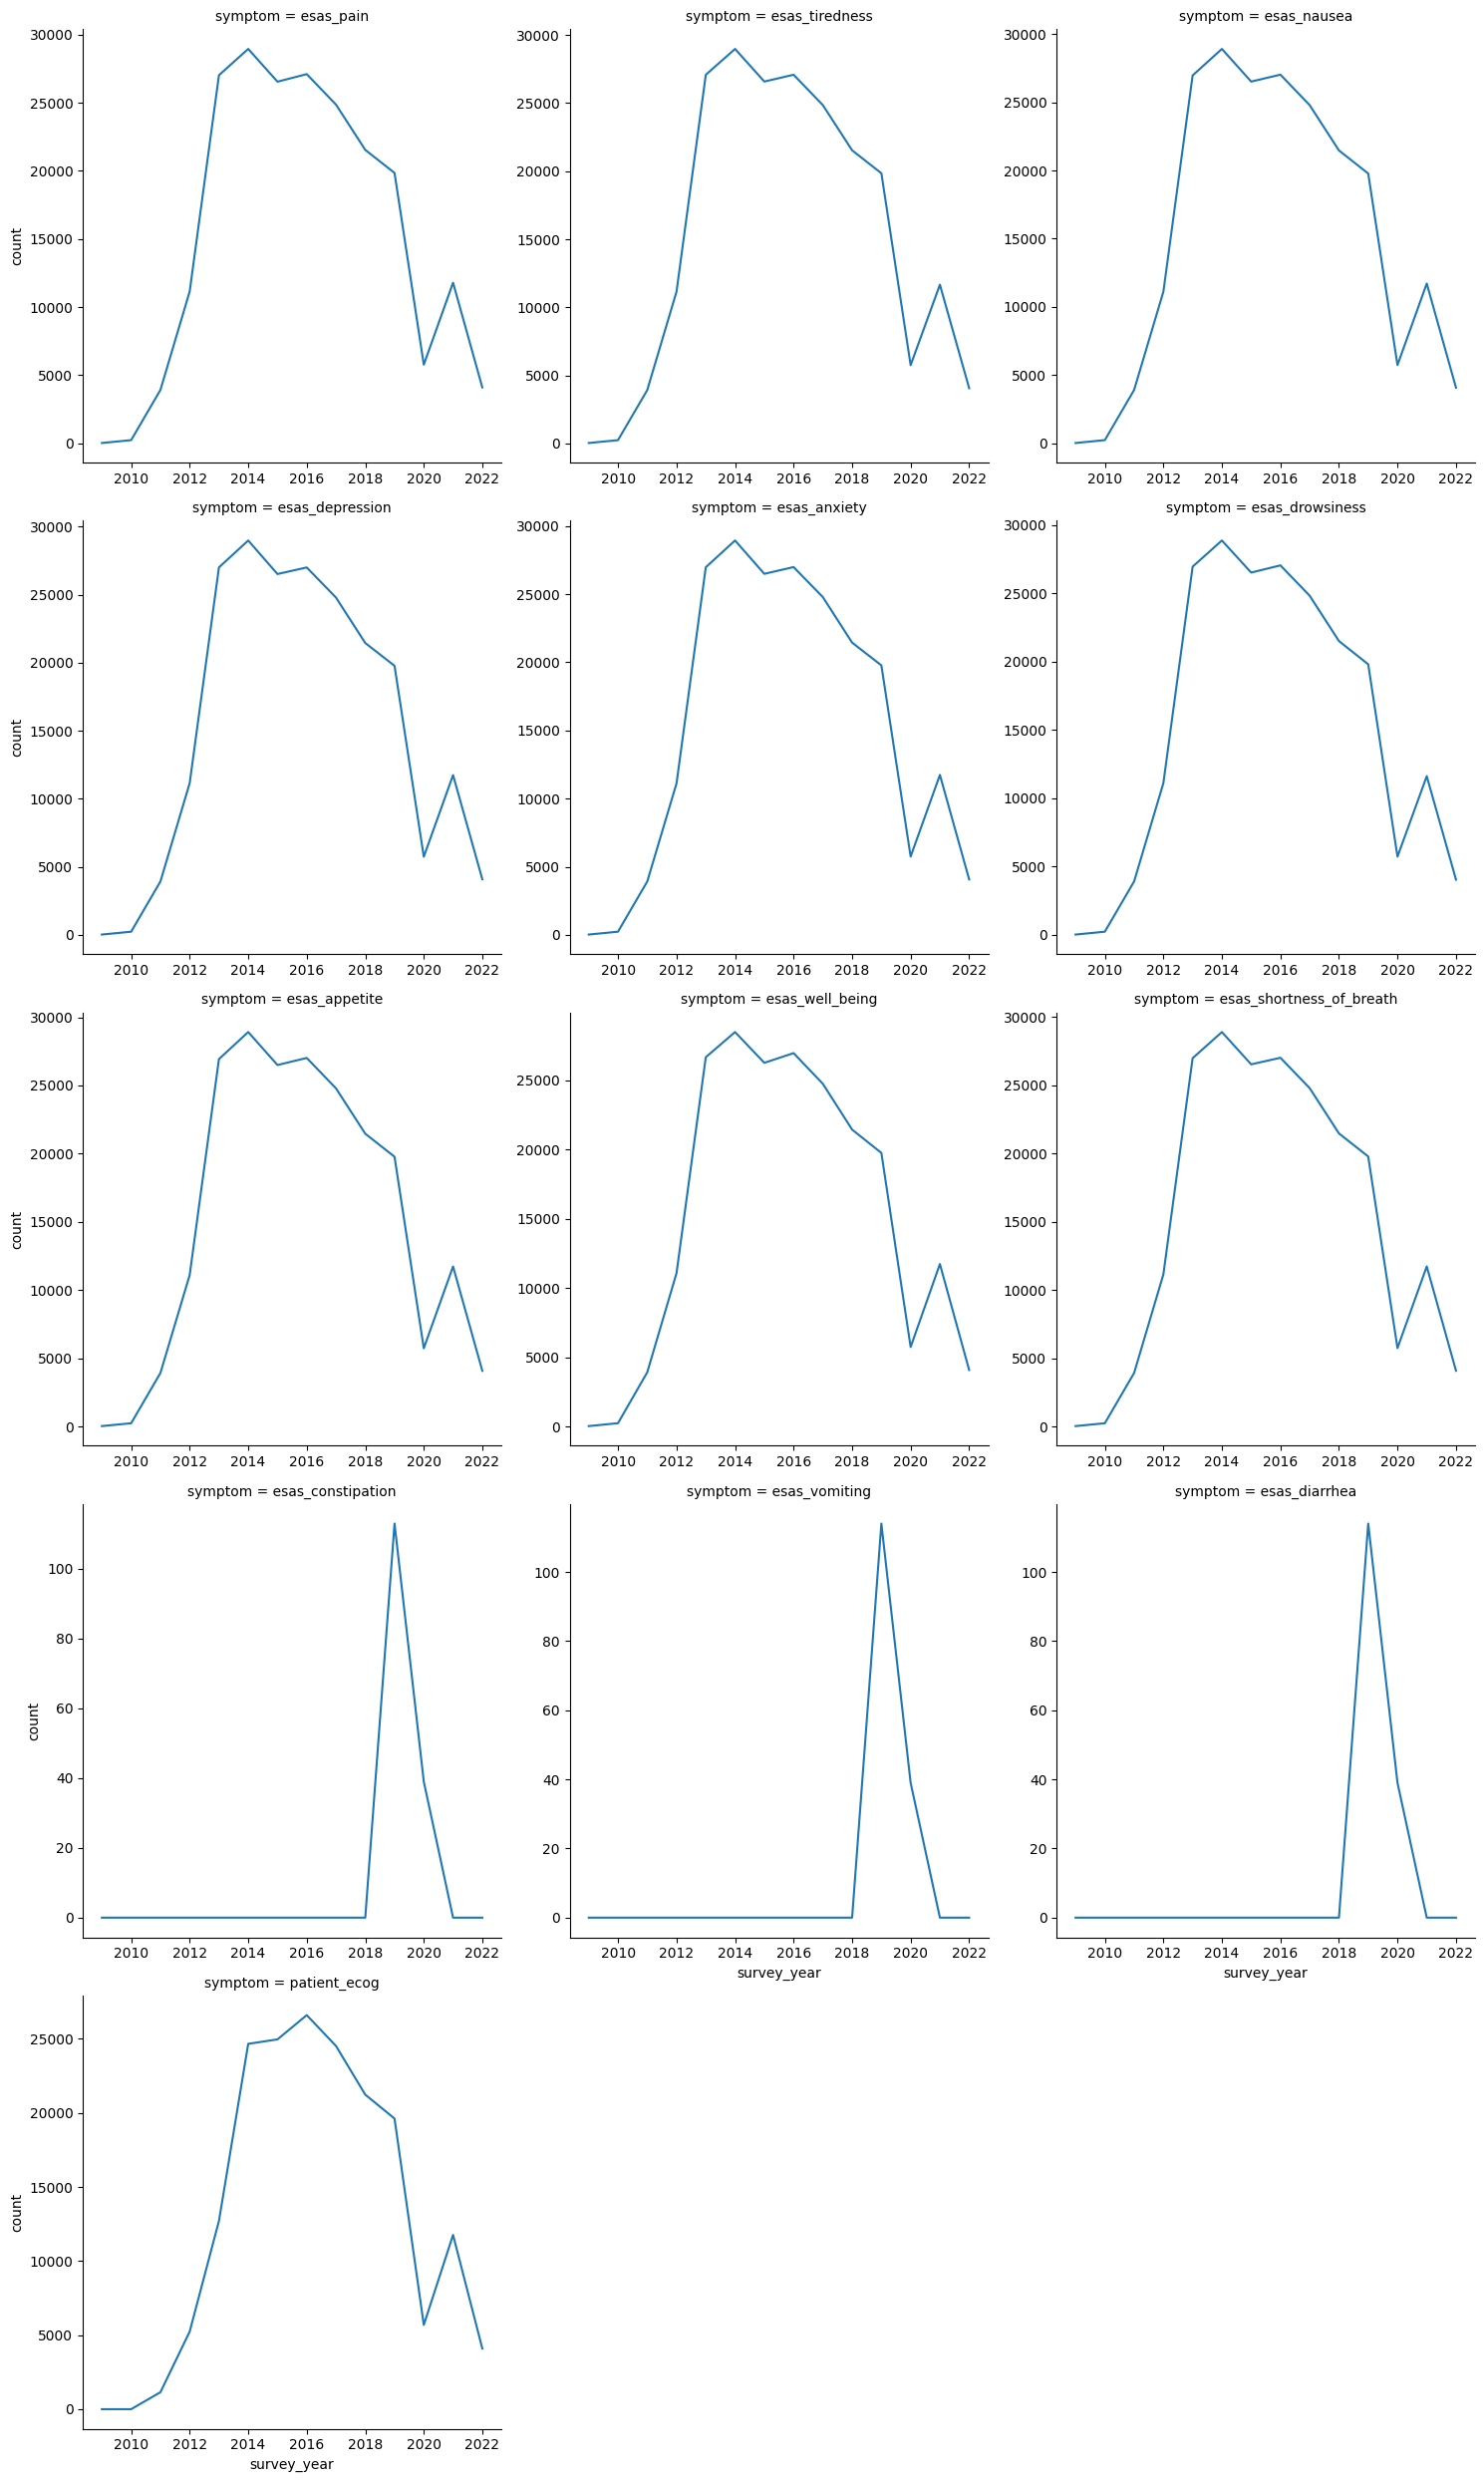

In [9]:
symp['survey_year'] = pd.to_datetime(symp['survey_date']).dt.year
cols = symp.columns.drop(['mrn', 'survey_year', 'survey_date'])
counts = symp.groupby('survey_year').apply(lambda g: g[cols].notnull().sum())
counts = counts.reset_index().melt('survey_year', var_name='symptom', value_name='count')
g = sns.relplot(
    data=counts, x='survey_year', y='count', col='symptom', col_wrap=3, kind='line', 
    facet_kws={'sharex': False, 'sharey': False}
)

## Score distribution

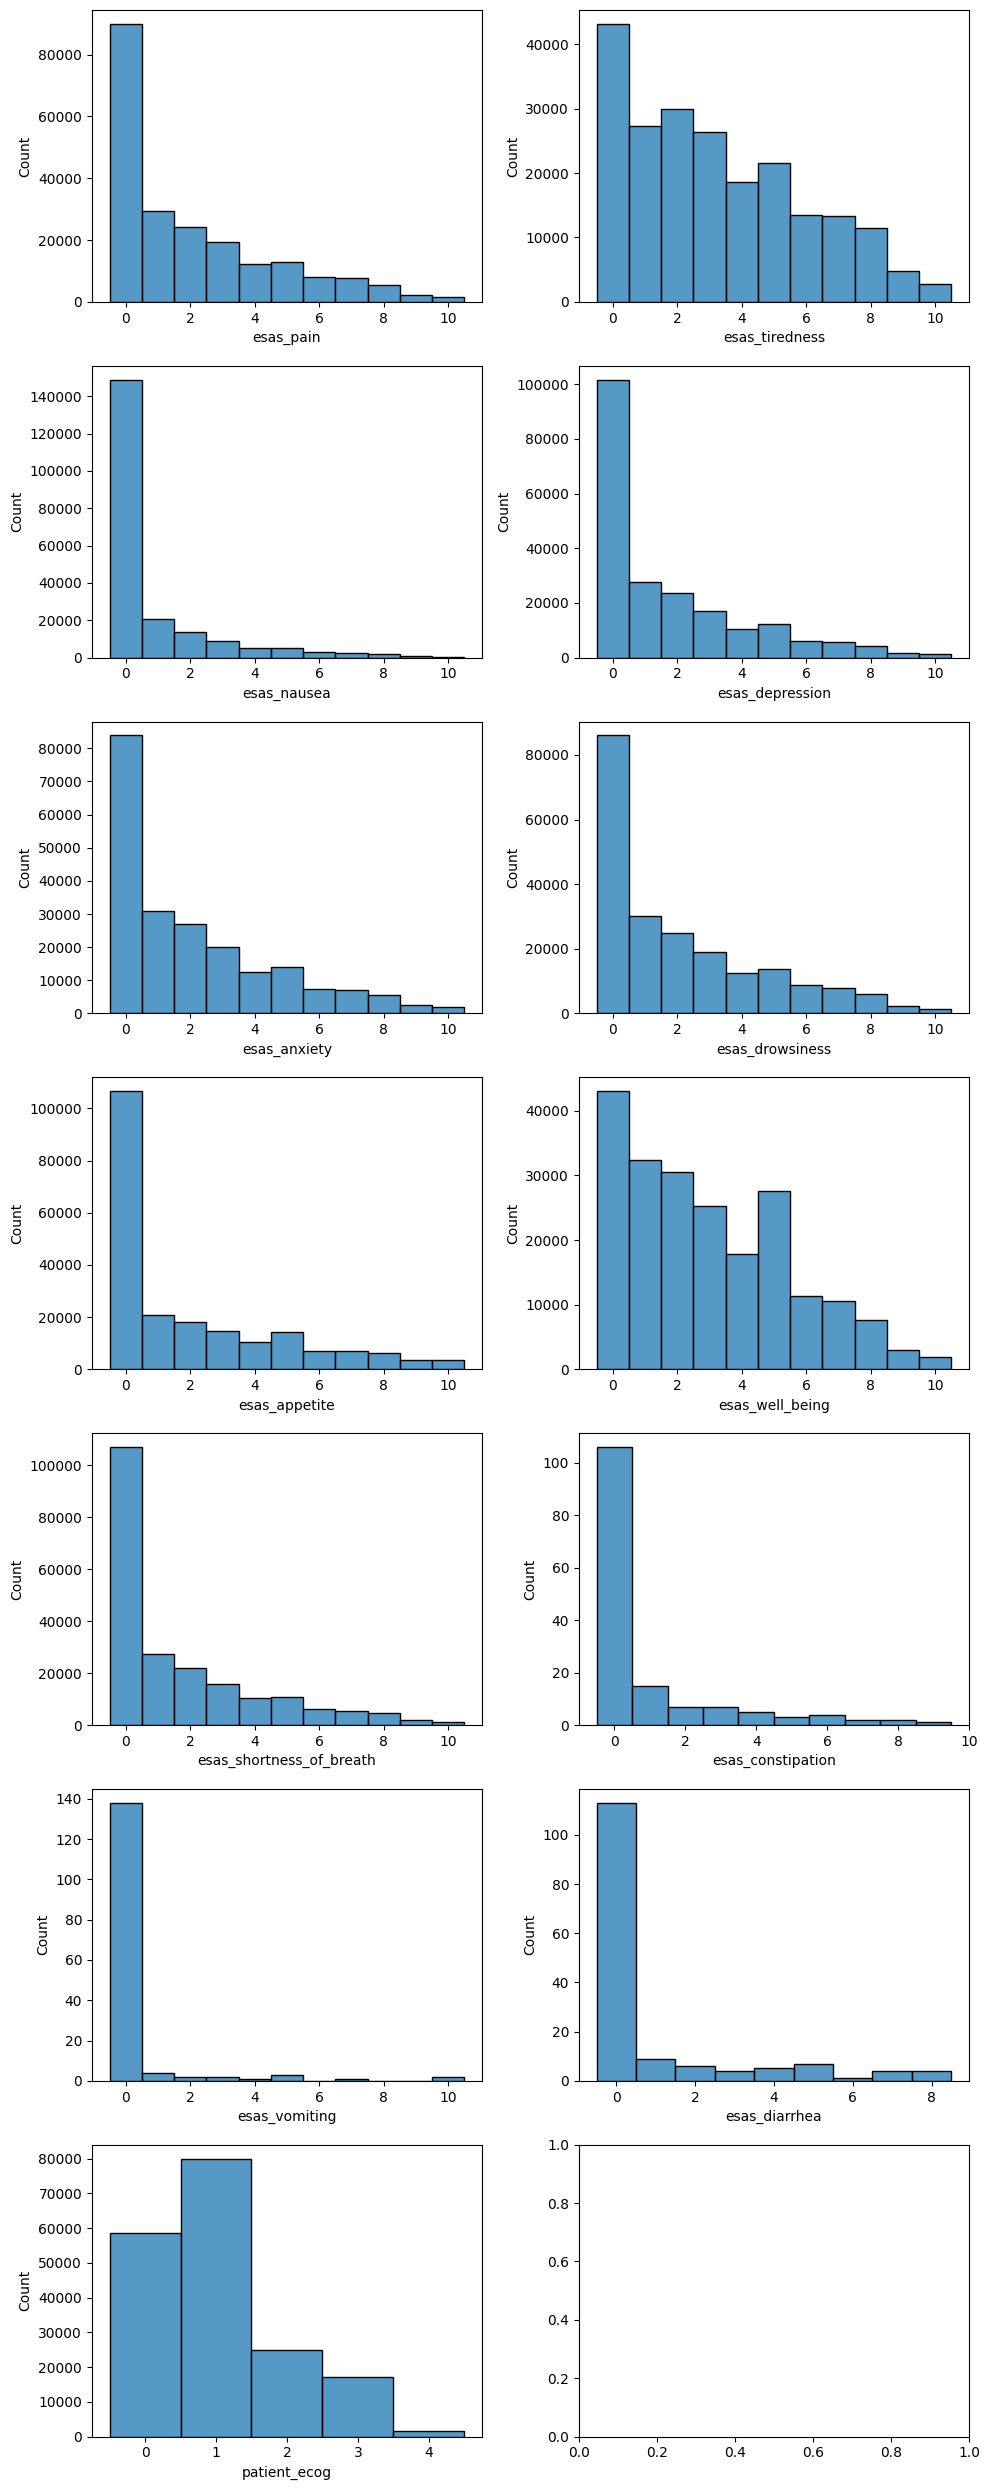

In [28]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(cols)/2)), ncols=2, figsize=(10,25))
axes = axes.flatten()
for idx, col in enumerate(cols): 
    sns.histplot(symp[col], ax=axes[idx], discrete=True)
plt.tight_layout()

## Compare demographic info with cancer registry

In [68]:
canc_reg = pd.read_parquet(f'{ROOT_DIR}/data/raw/cancer_registry.parquet.gzip')
mrns = list(set(canc_reg['MEDICAL_RECORD_NUMBER']).intersection(dart['MRN']))
canc_reg_sex = canc_reg.groupby('MEDICAL_RECORD_NUMBER')['SEX'].unique()[mrns]
dart_sex = dart.groupby('MRN')['GENDER'].unique()[mrns]
mrns_with_conflict = [mrn for mrn in mrns if any(canc_reg_sex[mrn] != dart_sex[mrn]) or len(dart_sex[mrn]) > 1]
print(f'{len(mrns_with_conflict)} patients with conflicting sex info out of {len(dart_sex)} overlapping patients')

503 patients with conflicting sex info out of 27141 overlapping patients


# Treatment Data

In [4]:
opis = pd.read_parquet(f'{ROOT_DIR}/data/raw/opis.parquet.gzip')
trt = pd.read_parquet(f'{ROOT_DIR}/data/interim/treatment.parquet.gzip')

## Intent

In [ ]:
"""
Usually, after palliative intent treatment, rest of the treatment remains palliative.

Check the number of cases where that is not true.
"""
def check_intent_stays_palliative(df):
    mask = df['intent'] == 'PALLIATIVE'
    if not mask.any():
        return True
    idx = mask[mask].index[0]
    return all(mask.loc[idx:])

mask = trt.groupby('mrn').apply(check_intent_stays_palliative)
mask.value_counts()

True     10193
False      122
dtype: int64

<Axes: xlabel='treatment_year'>

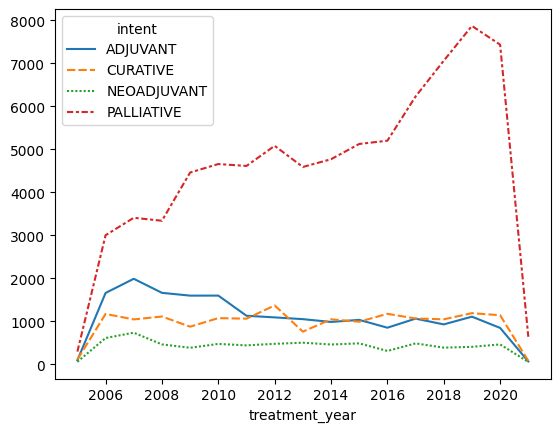

In [33]:
"""Number of treatments over time"""
trt['treatment_year'] = trt['treatment_date'].dt.year
counts = trt.groupby('treatment_year')['intent'].value_counts()
counts = pd.DataFrame(counts).rename(columns={'intent': 'count'}).reset_index()
counts = counts.pivot(index='treatment_year', columns='intent', values='count')
sns.lineplot(data=counts)

## First Treatment Date

In [ ]:
"""
Usually, the first treatment date is monotonically increasing (patients do not continue old treatment after starting new treatment)

Check the number of cases where that is not true.
"""
mask = trt.groupby('mrn').apply(lambda g: all(g['first_treatment_date'] == sorted(g['first_treatment_date'])))
mask.value_counts()

True     10109
False      206
dtype: int64

## Height and Weight

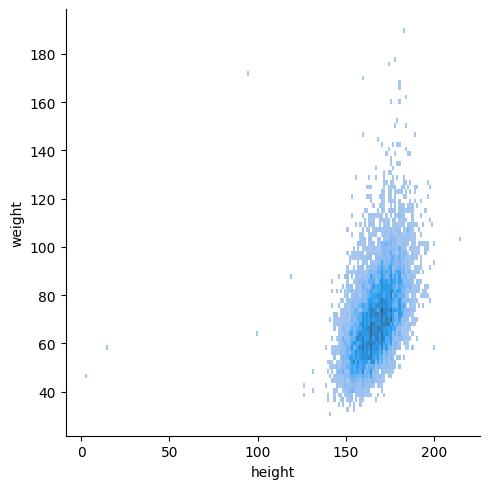

In [42]:
"""Height/weight distribution of patients undertaking treatment""" 
height_and_weight = trt.groupby('mrn').agg({'height': 'mean', 'weight': 'mean'})
sns.displot(data=height_and_weight, x='height', y='weight')

## Drugs

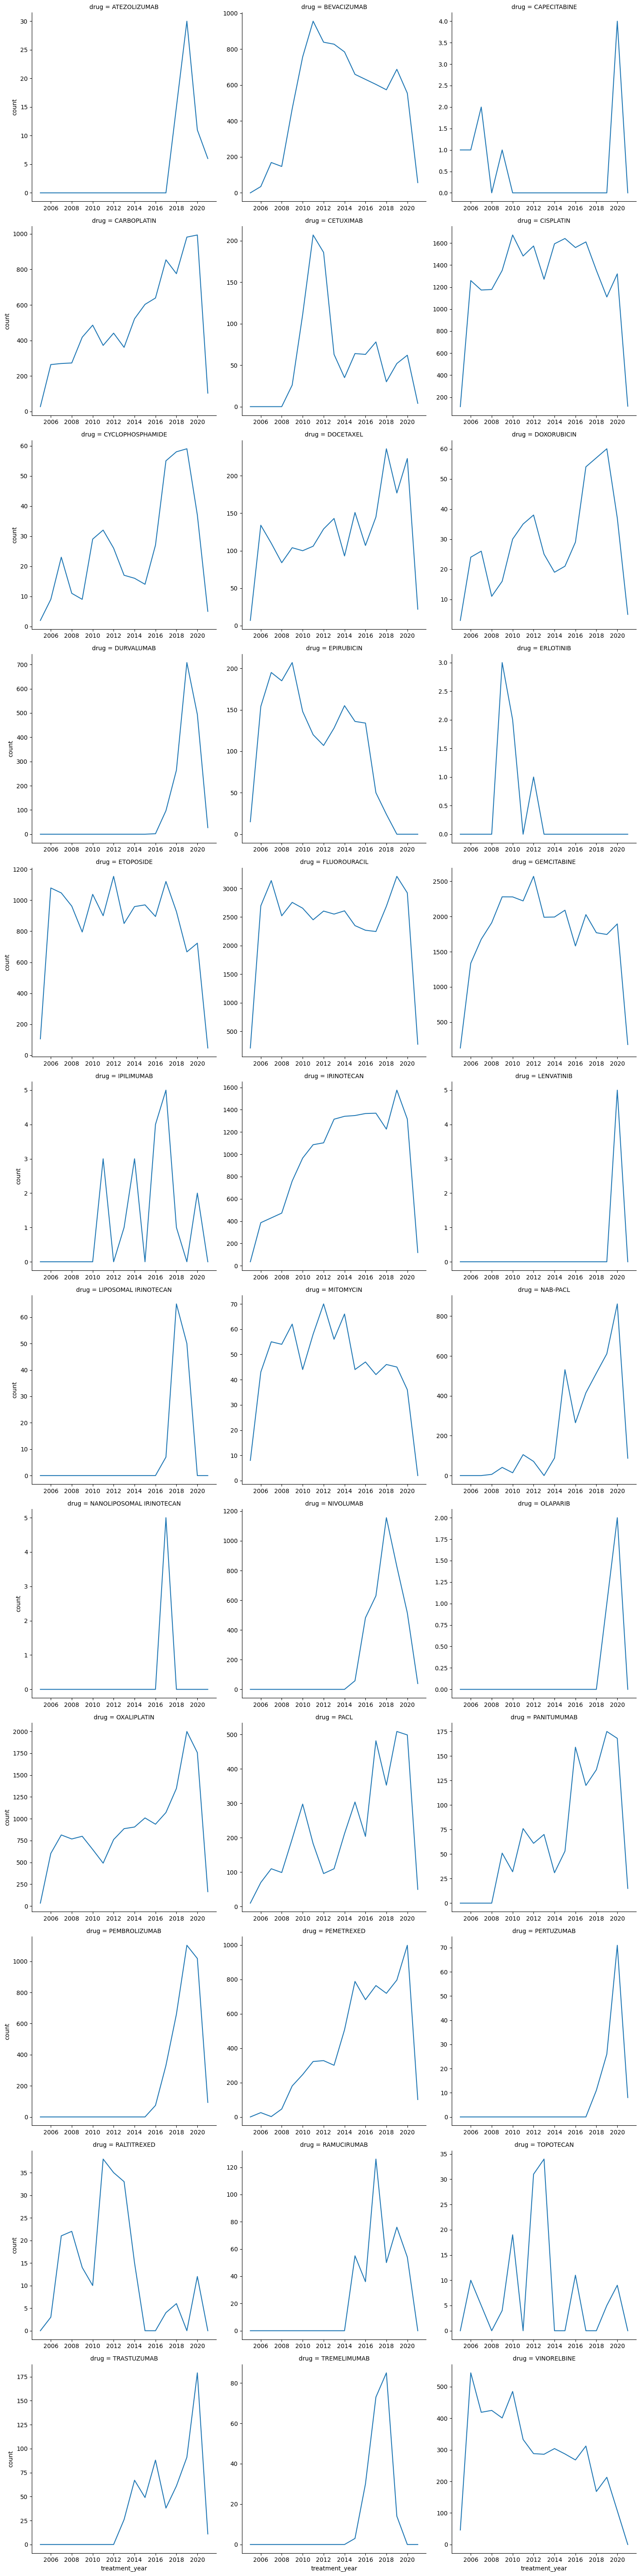

In [55]:
"""Number of drugs administered over time"""
trt['treatment_year'] = trt['treatment_date'].dt.year
cols = trt.columns
drug_cols = cols[cols.str.endswith('given_dose')]
counts = trt.groupby('treatment_year').apply(lambda g: (g[drug_cols] != 0).sum())
counts = counts.rename(columns={col: col.replace('drug_', '').replace('_given_dose', '') for col in drug_cols})
counts = counts.reset_index().melt('treatment_year', var_name='drug', value_name='count')
g = sns.relplot(
    data=counts, x='treatment_year', y='count', col='drug', col_wrap=3, kind='line', 
    facet_kws={'sharex': False, 'sharey': False}
)

In [5]:
"""
Check the number of cases where the dose given differed from dose ordered
"""
mask = (opis['Dose_Given'] == opis['Dose_Ord'])
mask.value_counts()

True     389575
False       263
dtype: int64

## Days Since Prev Session

In [6]:
# check the number of cases for each days since prev session
pd.concat([
    trt['days_since_last_treatment'].value_counts(),
    trt.groupby('days_since_last_treatment').apply(lambda g: g['mrn'].nunique())
], axis=1, keys=['Sessions', 'Patients']).sort_index().head(n=100)

Sessions  Patients
1.0       17404      2241
2.0         271       223
3.0        1923       841
4.0         747       277
5.0          75        73
6.0         445       388
7.0       22523      4379
8.0         771       579
9.0         121       104
10.0         91        86
11.0        124       120
12.0        315       279
13.0       1508      1070
14.0      26863      4373
15.0       1461      1126
16.0        584       523
17.0        512       449
18.0        399       364
19.0        753       509
20.0        984       881
21.0      13083      4492
22.0       1137      1008
23.0        542       514
24.0        828       704
25.0        890       824
26.0        937       608
27.0        560       521
28.0       5401      2238
29.0        474       429
30.0        211       202
31.0        286       275
32.0        246       229
33.0        161       157
34.0        136       133
35.0        840       710
36.0        133       132
37.0         81        81
38.0         77        76
39.0         83        83
40.0         68        66
41.0         83        83
42.0        786       574
43.0         68        68
44.0         49        49
45.0         42        42
46.0         65        65
47.0         31        31
48.0         54        54
49.0        231       223
50.0         38        37
51.0         26        26
52.0         31        31
53.0         28        27
54.0         22        22
55.0         40        40
56.0        223       198
57.0         41        41
58.0         22        22
59.0         21        21
60.0         22        22
61.0         21        21
62.0         30        30
63.0        128       125
64.0         32        32
65.0          6         6
66.0         10        10
67.0         21        21
68.0         18        18
69.0         25        25
70.0        112       107
71.0         25        25
72.0          8         8
73.0         11        11
74.0         18        18
75.0         12        12
76.0         22        22
77.0         80        80
78.0         17        17
79.0         13        13
80.0         11        11
81.0         10        10
82.0         15        15
83.0         24        24
84.0         92        88
85.0         20        20
86.0         14        14
87.0         13        13
88.0         15        15
89.0          9         9
90.0         17        17
91.0         70        70
92.0         25        24
93.0          8         8
94.0         14        14
95.0         12        12
96.0         14        14
97.0         16        16
98.0         58        58
99.0         14        14
100.0        13        13

# Emerg Data

In [4]:
er_visit = pd.read_parquet(f'{ROOT_DIR}/data/raw/ER.parquet.gzip')
erv = pd.read_parquet(f'{ROOT_DIR}/data/interim/emergency_room_visit.parquet.gzip')

## ER Reason

In [5]:
erv['CEDIS_complaint'].value_counts().head(100)

CEDIS_complaint
Abdominal pain                                         4081
Shortness of breath-SOB                                2804
General weakness                                       2266
Chest Pain-cardiac features                            1701
Medical device problem                                 1537
Fever unspecified                                      1457
Direct referral for consultation (Z71.9),              1116
Abnormal lab values                                     837
Nausea and/or vomiting                                  797
Back pain                                               784
Localized swelling/redness                              521
Blood in stool/Melena                                   505
Lower extremity pain                                    488
Shortness of breath (SOB)                               460
Lower extremity                                         458
Fever                                                   428
Headache                

In [10]:
# how often do CEDIS_complaint and chief_complaint deviate
mask = erv['CEDIS_complaint'].str.lower() == erv['chief_complaint'].str.lower()
mask.value_counts()

False    36571
True     12403
Name: count, dtype: int64

# Death Data

In [8]:
cancer_registry_ddates = pd.read_parquet('./data/raw/cancer_registry.parquet.gzip')
epr_death_ddates = pd.read_parquet('./data/raw/death_dates.parquet.gzip')
cancer_registry_ddates.rename(columns={'MEDICAL_RECORD_NUMBER': 'mrn', 'DATE_OF_DEATH': 'date_of_death'}, inplace=True)
epr_death_ddates.rename(columns={'MEDICAL_RECORD_NUMBER': 'mrn', 'DATE_OF_DEATH': 'date_of_death'}, inplace=True)
epr_death_ddates['date_of_death'] = pd.to_datetime(epr_death_ddates['date_of_death'], format='%d%b%Y:%H:%M:%S')
assert epr_death_ddates['date_of_death'].notnull().all() and not epr_death_ddates['mrn'].duplicated().any()
df = pd.merge(cancer_registry_ddates, epr_death_ddates, on ='mrn', how='left', suffixes=('_cr', '_epr'))

In [9]:
mask1 = df[['date_of_death_cr', 'date_of_death_epr']].notnull().all(axis=1)
mask2 = df['date_of_death_cr'].dt.date != df['date_of_death_epr']
tmp = df[mask1 & mask2]
diff = tmp['date_of_death_cr'] - tmp['date_of_death_epr']
mask = diff.dt.days.abs() > 3
conflicting_death_dates = tmp[mask].groupby('mrn')[['date_of_death_cr', 'date_of_death_epr']].first()
print(f'There are {len(conflicting_death_dates)} patients with conflicting death dates greater than 3 days')
mask = df['date_of_death_epr'].notnull() & df['date_of_death_cr'].isnull()
print(f'There are {sum(mask)} patients with death dates in the EPR death dataset but not in the Cancer Registry dataset')
mask = df['date_of_death_cr'].notnull() & df['date_of_death_epr'].isnull()
print(f'There are {sum(mask)} patients with death dates in the Cancer Registry dataset but not in EPR death dataset')

There are 333 patients with conflicting death dates greater than 3 days
There are 151 patients with death dates in the EPR death dataset but not in the Cancer Registry dataset
There are 10910 patients with death dates in the Cancer Registry dataset but not in EPR death dataset


# Demographic / Cancer Data

In [26]:
dmg = pd.read_parquet(f'{ROOT_DIR}/data/interim/demographic.parquet.gzip')
canc_cols = [col for col in dmg.columns if col.startswith('cancer_site')]

In [27]:
# number of patients diagnosed with multiple cancers
mask = dmg[canc_cols].notnull().sum(axis=1) > 1
mask.value_counts()

False    51159
True      1209
Name: count, dtype: int64

In [28]:
# number of patients diagnosed with two different cancers on the same day
mask = dmg[cols].nunique(axis=1) != dmg[cols].notnull().sum(axis=1)
mask.value_counts()

False    52259
True       109
Name: count, dtype: int64